In [1]:
'''
This file should be helpful to gain all the parameters of a tuneup, 
save them to this notebook for recall, 
and copy it into wherever you're storing the data for reference
'''
from hatdrivers.Keysight_N5183B import Keysight_N5183B
from hatdrivers.Yokogawa_GS200 import YOKO
from hatdrivers.SignalCore_sc5511a import SignalCore_SC5511A
from hatdrivers.MiniCircuits_Switch import MiniCircuits_Switch
from hatdrivers.switch_control import SWT as SWTCTRL
from hatdrivers.Keysight_MXA_N9020A import Keysight_MXA_N9020A
# from hatdrivers.Tektronix_AWG5014C import Tektronix_AWG5014C
from hatdrivers import DLL
# from hatdrivers.YROKO import YROKO_Client

#customized drivers
from hatdrivers.Hat_P9374A import Hat_P9374A
from hatdrivers.Hat_ENA5071C  import Hat_ENA5071C
#Metainstruments and tools ... 
from hatdrivers.meta_instruments import Modes

from hatdrivers.Hat_AWG5014C import Hat_AWG5014C
from qcodes.instrument_drivers.tektronix.AWG5014 import Tektronix_AWG5014

%matplotlib nbagg
import broadbean as bb
from broadbean.plotting import plotter
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['figure.figsize'] = (8, 3)
mpl.rcParams['figure.subplot.bottom'] = 0.15


C:\Users\Hatlab_3\.conda\envs\qcodes\lib\site-packages\visa.py:23: FutureWarning: The visa module provided by PyVISA is being deprecated. You can replace `import visa` by `import pyvisa as visa` to achieve the same effect.

The reason for the deprecation is the possible conflict with the visa package provided by the https://github.com/visa-sdk/visa-python which can result in hard to debug situations.
  FutureWarning,


In [2]:
#initialize the instruments: 
awg = Tektronix_AWG5014('AWG2', 'TCPIP0::169.254.116.102::inst0::INSTR', timeout=40)
CXA = Keysight_MXA_N9020A("CXA", address = 'TCPIP0::169.254.110.116::INSTR')
#%%SignalCores
dll_path = r'C:\Users\Hatlab_3\Desktop\RK_Scripts\New_Drivers\HatDrivers\DLL\sc5511a.dll'
SC5 = SignalCore_SC5511A('SigCore5', serial_number = '10001851', debug = True)
SC9 = SignalCore_SC5511A('SigCore9', serial_number = '1000190E', debug = True)

Connected to: TEKTRONIX AWG5014C (serial:B050109, firmware:SCPI:99.0 FW:4.6.0.7) in 0.25s
Connected to: Keysight Technologies N9000B (serial:MY60250463, firmware:A.28.05) in 0.06s
<CDLL 'c:\users\hatlab_3\desktop\rk_scripts\new_drivers\hatdrivers\hatdrivers\DLL//sc5511a.dll', handle 7ffdc3b70000 at 0x1efa294d608>
10001851 c_void_p(2128645421888)
check status 1
<CDLL 'c:\users\hatlab_3\desktop\rk_scripts\new_drivers\hatdrivers\hatdrivers\DLL//sc5511a.dll', handle 7ffdc3b70000 at 0x1efa39509c8>
1000190E c_void_p(2128638629200)
check status 1


In [14]:
#now check the status of the signalcores and turn them on at the right frequencies:
#for this amp at 0 bias the resonant frequency is at 6229339646.96
LO_freq = 6168000000.0
SC5.frequency(LO_freq)
SC9.frequency(LO_freq+50e6)
SC5.power(16)
SC9.power(16)
SC5.output_status(1)
SC9.output_status(1)

Count complete


<IPython.core.display.Javascript object>


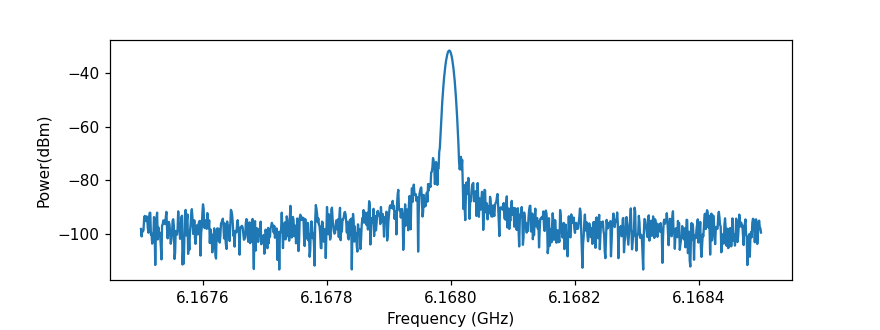

Max of trace: -31.53384209
Span: 1000000.0
RBW: 9100.0
VBW: 9100.0
Span: 1000000.0
RBW: 9100.0
VBW: 9100.0


In [16]:
#now we can tune the mixer leakage. Let's check out what's happening right now at the LO frequency
CXA.fcenter(LO_freq)
CXA.fspan(1e6)
CXA.plot_trace()
CXA.print_important_info()

<IPython.core.display.Javascript object>


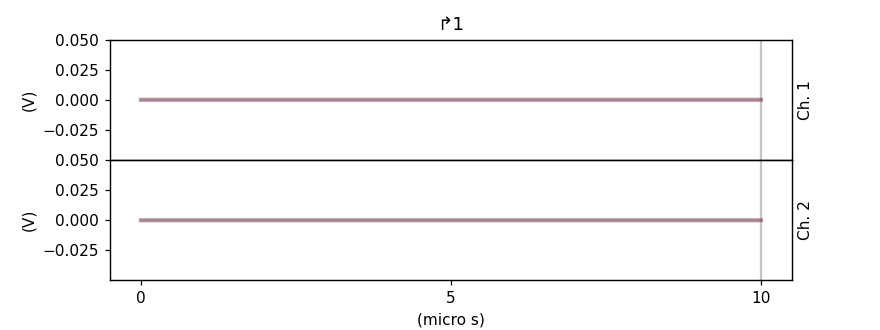

c:\users\hatlab_3\desktop\rk_scripts\broadbean\broadbean\broadbean\plotting.py:243: UserWarning: Attempting to set identical bottom == top == 0.0 results in singular transformations; automatically expanding.
  ax.set_ylim([ymin-0.05*yrange, ymax+0.2*yrange])
c:\users\hatlab_3\desktop\rk_scripts\broadbean\broadbean\broadbean\plotting.py:243: UserWarning: Attempting to set identical bottom == top == 0.0 results in singular transformations; automatically expanding.
  ax.set_ylim([ymin-0.05*yrange, ymax+0.2*yrange])


(None, None, None, None)

In [17]:
#so as you can see, we have bad LO leakage. 
#To fis this and prep the next stage, we are first going to load a test pulse into the AWG
def flat(ampl, SR, npts):
    return ampl*np.ones(npts)

tuneUp = bb.BluePrint()
tuneUp.insertSegment(0, flat, (0), name='plateau', dur=1e-5)
tuneUp.setSR(1e9)

tuneUpEl = bb.Element()
tuneUpEl.addBluePrint(1, tuneUp)
tuneUpEl.addBluePrint(2, tuneUp)

tuneUpSeq = bb.Sequence()
tuneUpSeq.addElement(1, tuneUpEl)
tuneUpSeq.setSR(1e9)
tuneUpSeq.setChannelAmplitude(1, 3)  # Call signature: channel, amplitude (peak-to-peak)
tuneUpSeq.setChannelAmplitude(2, 3) 
tuneUpSeq.setSequencingTriggerWait(1, 0)
tuneUpSeq.setSequencingNumberOfRepetitions(1, 1)
tuneUpSeq.setSequencingEventJumpTarget(1, 0)
tuneUpSeq.setSequencingGoto(1, 1) #infinite loop
tuneUpSeq.setChannelOffset(1, 0)
tuneUpSeq.setChannelOffset(2, 0)

tuneUpSeq.checkConsistency()
plotter(tuneUpSeq)

#upload to awg and reset offsets
package = tuneUpSeq.outputForAWGFile()
chan1_awg_input = package[0]
chan2_awg_input = package[1]
package.channels
awg.make_send_and_load_awg_file(*package[:])
awg.ch1_offset(0), awg.ch2_offset(0), awg.ch3_offset(0), awg.ch4_offset(0)


In [18]:
#run this when you've manually tuned the offsets
good_offsets = (awg.ch1_offset(), awg.ch2_offset(), awg.ch3_offset(), awg.ch4_offset())
print(good_offsets)

(-0.079, -0.12, 0.0, 0.0)


Span: 1000000.0
RBW: 9100.0
VBW: 9100.0
Count complete


<IPython.core.display.Javascript object>


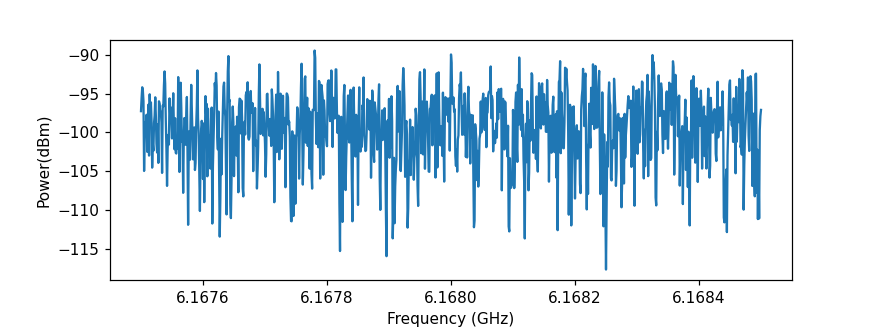

Max of trace: -89.43350983
Span: 1000000.0
RBW: 9100.0
VBW: 9100.0


-89.43350983

In [19]:
awg.ch1_offset(good_offsets[0])
awg.ch2_offset(good_offsets[1])
awg.ch1_state(1)
awg.ch2_state(1)
import time
time.sleep(0.5)
CXA.print_important_info()
CXA.plot_trace()

Running test.
Count complete


<IPython.core.display.Javascript object>


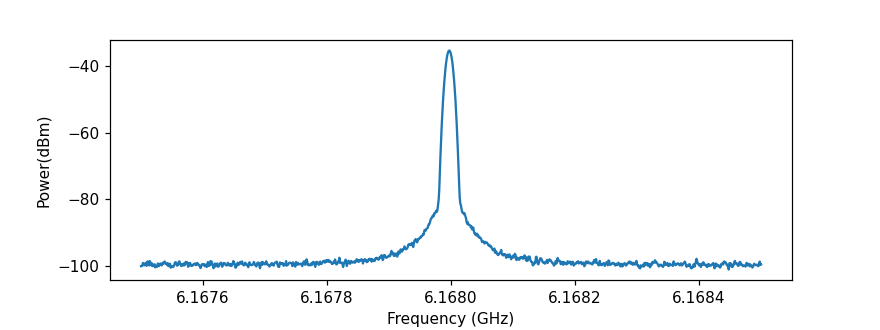

Max of trace: -35.22964776
Span: 1000000.0
RBW: 9100.0
VBW: 9100.0


In [20]:
'''
not much of a peak anymore! DC leakage is good
now we move onto amplitude imbalance. 
here we change the amplitude of one channel at a time to a constant value, 1 volt, 
and then compare the spectrum magnitude to when the other channel is set to that same magnitude
'''
import time
#turning on channel 1
tuneUpSeq.element(1).changeArg(1, 'plateau', 'ampl', 1/np.sqrt(2))
tuneUpSeq.element(1).changeArg(2, 'plateau', 'ampl', 0)
package = tuneUpSeq.outputForAWGFile()
awg.make_send_and_load_awg_file(*package[:])
awg.ch1_state(1)
awg.ch2_state(1)
time.sleep(0.5)
ch1_pow = CXA.plot_trace(avgnum = 100)


<IPython.core.display.Javascript object>


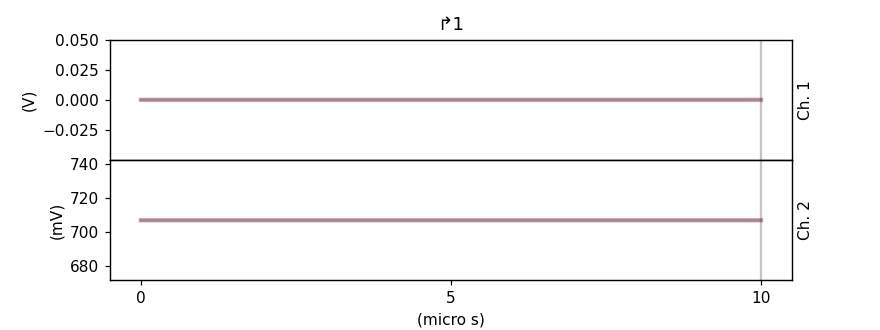

c:\users\hatlab_3\desktop\rk_scripts\broadbean\broadbean\broadbean\plotting.py:243: UserWarning: Attempting to set identical bottom == top == 0.0 results in singular transformations; automatically expanding.
  ax.set_ylim([ymin-0.05*yrange, ymax+0.2*yrange])
c:\users\hatlab_3\desktop\rk_scripts\broadbean\broadbean\broadbean\plotting.py:243: UserWarning: Attempting to set identical bottom == top == 707.1067811865474 results in singular transformations; automatically expanding.
  ax.set_ylim([ymin-0.05*yrange, ymax+0.2*yrange])


Running test.
Count complete


<IPython.core.display.Javascript object>


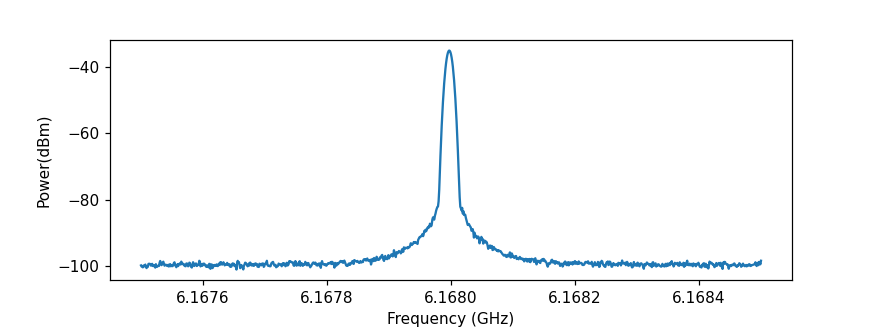

Max of trace: -35.1792416
Span: 1000000.0
RBW: 9100.0
VBW: 9100.0


In [21]:
#that was channel 1, so I, now for Q: 
#turning on channel 2
tuneUpSeq.element(1).changeArg(1, 'plateau', 'ampl', 0)
tuneUpSeq.element(1).changeArg(2, 'plateau', 'ampl', 1/np.sqrt(2))
plotter(tuneUpSeq)
package = tuneUpSeq.outputForAWGFile()
awg.make_send_and_load_awg_file(*package[:])
awg.ch1_state(1)
awg.ch2_state(1)
time.sleep(0.5)
ch2_pow = CXA.plot_trace(avgnum = 100)

In [22]:
#there we go, so we have our amplitude imbalance
def amplitude_correction(ch1_amp, ch2_amp, perfect_channel = 1): 
    '''
    this function will do the log linear conversion from dbm 
    to voltage and do the division to determine the amplitude correction factor
    '''
    perfect_channel -=1 #change to array notation
    channels = np.array([ch1_amp, ch2_amp])
    linear_power = np.power(np.array([10,10]), channels/20)*1e-3 #dB(milliwatt)
    voltage = np.sqrt(linear_power)
    correction_factor = voltage[perfect_channel]/voltage[(perfect_channel+1) % 2]
    return correction_factor

ch2_correction = amplitude_correction(ch1_pow,ch2_pow, perfect_channel = 1)    
print(f"Ch2_correction: {ch2_correction}")

Ch2_correction: 0.9971025937916236


Running test.
Count complete


<IPython.core.display.Javascript object>


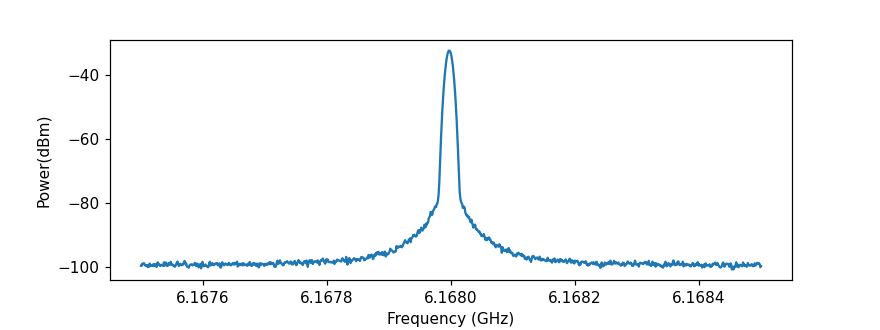

Max of trace: -32.40055821
Span: 1000000.0
RBW: 9100.0
VBW: 9100.0


In [23]:
'''now that we know the amplitude correction factor, 
we can turn both channels on WITH correction and 
measure the change in amplitude to get the phase correction.
'''
#turning on both channels
tuneUpSeq.element(1).changeArg(1, 'plateau', 'ampl', 1/np.sqrt(2))
tuneUpSeq.element(1).changeArg(2, 'plateau', 'ampl', 1*ch2_correction/np.sqrt(2))

package = tuneUpSeq.outputForAWGFile()
awg.make_send_and_load_awg_file(*package[:])
awg.ch1_state(1)
awg.ch2_state(1)
time.sleep(1)
combined_pow = CXA.plot_trace(avgnum = 100)

In [24]:
#when you're done, run this cell to print a summary: 
print(f"Ch1 by itself: {ch1_pow}")
print(f"Combined Power: {combined_pow}")
print(f"Difference In Power: {combined_pow-ch1_pow}")
linear_ratio = np.sqrt(np.power(10, (combined_pow-ch1_pow)/10))
print(f"Difference In Power (linear voltage ratio): {linear_ratio}")

Ch1 by itself: -35.22964776
Combined Power: -32.40055821
Difference In Power: 2.829089549999999
Difference In Power (linear voltage ratio): 1.3850150018326484


In [25]:
#difference isn't quite 3dBm,
#so now we can use some geometry to calculate what the phase offset is. 
def calculate_phase_offset(linear_ratio): 
    phi_offset = -np.arccos(-0.5*np.sqrt(-linear_ratio**2*(-4+linear_ratio**2)))
    #we want the smallest change, so we can check this value +-2pi
    phi_array = [phi_offset, phi_offset+np.pi, phi_offset-np.pi]
    return phi_array[np.abs(phi_array).argmin()]

phase_offset = calculate_phase_offset(linear_ratio)
print(f"Phase Offset: {phase_offset}")

Phase Offset: 0.040878106083876986


In [26]:
#print a total summary: 
print(f"DC Offsets: {good_offsets}")
print(f"Ch2 voltage correction factor: {ch2_correction}")
print(f"Phase Offset: {phase_offset}")

DC Offsets: (-0.079, -0.12, 0.0, 0.0)
Ch2 voltage correction factor: 0.9971025937916236
Phase Offset: 0.040878106083876986


In [40]:
#now we have the IQ corrections to any pulse on this hardware setup (same cables, same mixer) that we need!

'''
So if before, we had a signal that was split into I(t) = A1(t)Sin(phi(t)) on channel 1 and Q(t) = A2(t)Cos(phi(t))

Then our new signal is I'(t) = I(t) and Q'(t) = A2(t)*A2_corr*Cos(phi(t)-phase_corr)
'''

